In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
from PIL import Image
import glob

In [17]:
with open ("objectpoints.pkl", "rb") as f:
# Read in the saved objpoints and imgpoints
    objectpoints = pickle.load(f)
with open("imgpoints.pkl", "rb") as g:
    imgpoints = pickle.load(g)
    
def undistort(img, objpoints, imgpoints):
    """
    This function undistorts an img by given camera specific objectpoints and imgpoints. Output is the
    undistorted image.
    Input: img
    Out: undist 
    """
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def combined_thresholded_img(img):
    # gradient threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_sobel = abs_sobel_thresh(gray,"x",40,200)   #40,200
    y_sobel = abs_sobel_thresh(gray,"y",40,200)   #40,200
    # dir threshold
    dir_th = dir_threshold(gray,3,(np.pi/6, np.pi/2)) # adapting thresholds
    # mag threshold
    mag = mag_thresh(gray, 17, (8,150)) #adapting thresholds 140,255
    # combining
    #combined_th = np.zeros_like(dir_th)
    combined = (((x_sobel==1)&(y_sobel ==1)) | ((mag == 1) & (dir_th == 1)))
    # Adding color Threshold
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    s_chl = hls[:,:,2]
    l_chl = lab[:,:,0]
    
    s_thresh = (95, 255) #95, 255
    s_condition = (s_chl > s_thresh[0]) & (s_chl <= s_thresh[1])
    
    # L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)   #120, 255
    l_condition = (l_chl > l_thresh[0]) & (l_chl <= l_thresh[1])

    # combine all thresholds
    combined_all = np.zeros_like(s_chl)
    combined_all[(r_g_condition & l_condition) & (s_condition | combined)] = 1
    
    # apply the region of interest mask
    h, w = gray.shape
    mask = np.zeros_like(combined_all)
    #region of interest
    ROI = np.array([[0,h-1], [w/2, int(0.5*h)], [w-1, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [ROI], 1)
    final_output = cv2.bitwise_and(combined_all, mask)
    return final_output
    
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output
    
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):   
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def warp(img,birdperspect=True):
    """
    This function transforms an img by the shape of (1280,720) (y,x) to an bird perspective. If the parameter
    'birdperspect' is set to False it transforms the img back to normal perspective. Also it gives the transformation matrix M
    Input: img, birdperspect = Ture
    Out: warped, M 
    """
    # define image
    img_size = (1280,720)
    #four source coordinates-- have to get adapted on another image! cell above to check
    src = np.float32(    
        [[720,470],
         [1185,720],
         [200,720],
         [565,470]])
    # four desired coordinates 
    dst = np.float32(
        [[920,1],
         [970,720],
         [320,720],
         [320,1]])
    # compute the perspective transformation matrix M
    if birdperspect:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    # create warped image:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M

def line_detect(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] ## allx, ally class

    # Fit a second order polynomial to each -- current coeff class
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ##
    ploty = np.linspace(0, warped.shape[0]-1,warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

    
def real_radius(ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # average Radius
    avg_radius = (left_curverad + right_curverad)/2000
    curvature_string = "Curve Radius: %.2f km" % avg_radius
    return curvature_string

def centeroffset (img, left_fitx,right_fitx):
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    # compute the offset from the center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    return offset_string #print(offset_string)

def back_transf(img,warped, left_fitx, right_fitx, ploty):
    if left_fitx is None or right_fitx is None:
        return img
    #Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 50))  #(0,255,0)
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    warp_back,Minv = warp(img, birdperspect = False)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def infos(output,curvature_string,offset_string):
    cv2.putText(output, curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(output, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    return output


In [11]:
def lanelinedetection(image):

    
    # Operations: 
    img = undistort(image,objectpoints,imgpoints)
    warped, Minv = warp(combined_thresholded_img(img))
    left_fitx, right_fitx, ploty = line_detect(warped)
    
    # Informations
    radius = real_radius(ploty,left_fitx, right_fitx)
    center_offset = centeroffset(img, left_fitx,right_fitx)
    # Output
    output = infos(back_transf(img,warped, left_fitx, right_fitx, ploty), radius, center_offset)
    return output

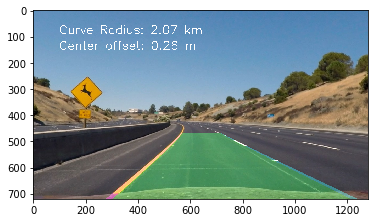

In [18]:
image = mpimg.imread('test_images/test2.jpg')
    
plt.imshow(lanelinedetection(image))
plt.show()


In [19]:
from moviepy.editor import VideoFileClip

## Reinitialize some global variables.
#polyfit_left = None
#polyfit_right = None
#past_good_right_lines = []
#past_good_left_lines = []
#running_mean_difference_between_lines = 0


output = 'project_video_output_v2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lanelinedetection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video project_video_output_v2.mp4
[MoviePy] Writing video project_video_output_v2.mp4



 24%|██▍       | 303/1261 [05:08<17:28,  1.09s/it]


 48%|████▊     | 605/1261 [10:23<11:41,  1.07s/it]


 72%|███████▏  | 907/1261 [15:30<06:25,  1.09s/it]


 96%|█████████▌| 1205/1261 [20:43<00:58,  1.05s/it]


100%|█████████▉| 1260/1261 [21:46<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_v2.mp4 

CPU times: user 50min 16s, sys: 4min 57s, total: 55min 13s
Wall time: 21min 48s


In [21]:
output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(lanelinedetection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 27%|██▋       | 133/485 [02:09<05:45,  1.02it/s]

TypeError: expected non-empty vector for x